# MFS demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.visibility.base import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, smooth_image, \
    calculate_image_frequency_moments, calculate_image_from_frequency_moments
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import  image_raster_iter
from arl.image.solvers import solve_image
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, \
    create_low_test_image_from_gleam, create_low_test_beam
from arl.imaging import *
from arl.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'


Construct LOW configuration

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=5 * 2048
    padding = 1
    context='2d'

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=512
    padding = 2
    context='2d'
    
oversampling = 32

nchan = 7
frequency = numpy.linspace(0.8e8, 1.2e8, nchan)
centre_frequency = numpy.array([numpy.average(frequency)])
channel_bandwidth=numpy.array(nchan * [frequency[1]-frequency[0]])
total_bandwidth = numpy.array([numpy.sum(channel_bandwidth)])

times = numpy.linspace(-3, +3, 5) * numpy.pi / 12.0
log.info('Observing times %s' % (times))
log.info("Observing frequencies %s Hz" % (frequency))
log.info("Channel bandwidths %s Hz" % (channel_bandwidth))
log.info("Centre frequency %s Hz" % (centre_frequency))
log.info("Cellsize = %.6f radians" % (cellsize))

Observing times [-0.78539816 -0.39269908  0.          0.39269908  0.78539816]
Observing frequencies [8.00000000e+07 8.66666667e+07 9.33333333e+07 1.00000000e+08
 1.06666667e+08 1.13333333e+08 1.20000000e+08] Hz
Channel bandwidths [6666666.66666667 6666666.66666667 6666666.66666667 6666666.66666667
 6666666.66666667 6666666.66666667 6666666.66666667] Hz
Centre frequency [1.e+08] Hz
Cellsize = 0.001000 radians


In [4]:
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 479325 rows, 0.050 GB


Plot the synthesized uv coverage

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


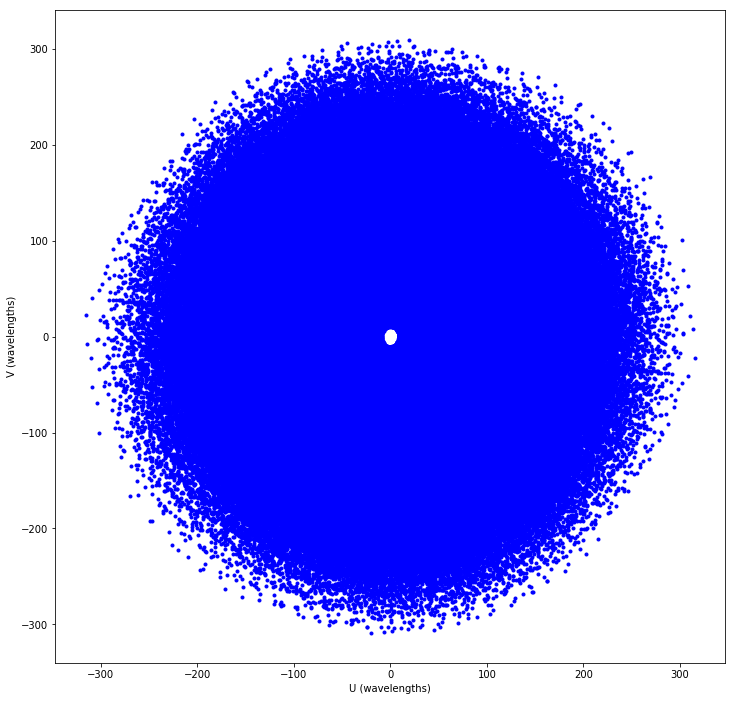

In [5]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Make a test image

In [6]:
model_centrechannel = create_low_test_image_from_gleam(npixel=npixel, 
                                                       frequency=centre_frequency, 
                                                       channel_bandwidth=total_bandwidth, 
                                                       cellsize=cellsize, 
                                                       phasecentre=phasecentre, applybeam=True)
export_image_to_fits(model_centrechannel, '%s/imaging-mfs-model_centre_channel.fits' % 
                     (results_dir))

create_low_test_skycomponents_from_gleam: 6330 sources above flux limit 0.100
insert_skycomponent: Using insert method Nearest
import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
Quality assessment:
	Origin: qa_image
	Context: create_low_test_image_from_gleam
	Data:
		shape: '(1, 1, 512, 512)'
		max: '4.323162979548169'
		min: '-4.2552058181497775e-05'
		rms: '0.022998325976221947'
		sum: '156.0256917294545'
		medianabs: '0.0'
		median: '0.0'



In [7]:
model_multichannel = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency, 
                                                      channel_bandwidth=channel_bandwidth, 
                                                      cellsize=cellsize, 
                                                      phasecentre=phasecentre, applybeam=True)

create_low_test_skycomponents_from_gleam: 6330 sources above flux limit 0.100
insert_skycomponent: Using insert method Nearest
import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
Quality assessment:
	Origin: qa_image
	Context: create_low_test_image_from_gleam
	Data:
		shape: '(7, 1, 512, 512)'
		max: '6.27413012127613'
		min: '-0.003133149111273175'
		rms: '0.02520752551921763'
		sum: '1199.6957022900947'
		medianabs: '0.0'
		median: '0.0'



findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


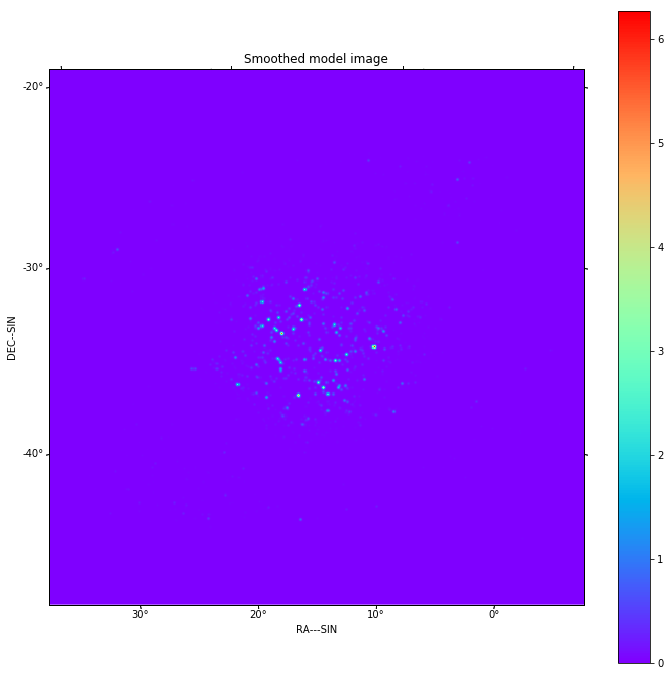

In [8]:
cmodel = smooth_image(model_multichannel)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()
export_image_to_fits(cmodel, '%s/imaging-mfs-cmodel.fits' % (results_dir))

In [9]:
export_image_to_fits(model_multichannel, '%s/imaging-mfs-multi_channel.fits' % (results_dir))
moment_cube = calculate_image_frequency_moments(model_multichannel,nmoments=3)
export_image_to_fits(moment_cube, '%s/imaging-mfs-moment_cube.fits' % (results_dir))

calculate_image_frequency_moments: Reference frequency = 100000000.000 (MHz)


In [10]:
reconstructed_cube = calculate_image_from_frequency_moments(model_multichannel, moment_cube)
export_image_to_fits(reconstructed_cube, '%s/imaging-mfs-reconstructed_cube.fits' % 
                     (results_dir))

calculate_image_from_frequency_moments: Reference frequency = 100000000.000 (MHz)


image_raster_iter: predicting using 1 x 1 image partitions


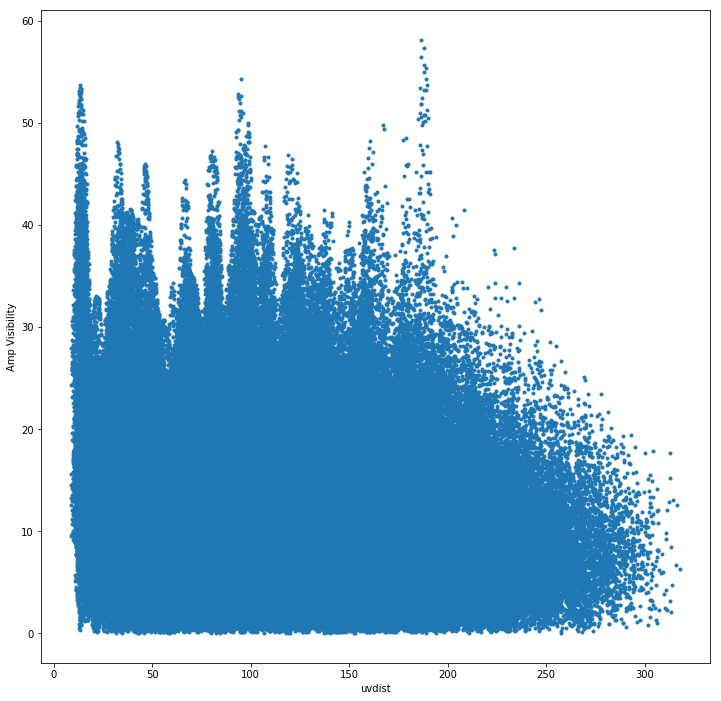

In [11]:
vt.data['vis'] *= 0.0
vt = predict_function(vt, model_multichannel, context='2d')

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Weight the data

weight_gridding: Performing uniform weighting
findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
findfont: Matching :family=STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode ('/Users/timc

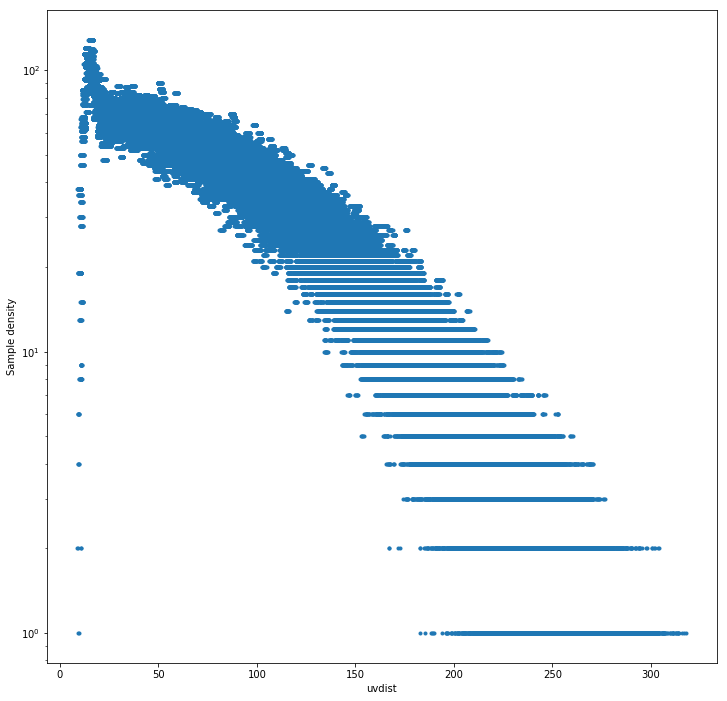

In [12]:
vt, density, densitygrid = weight_visibility(vt, model_centrechannel)
plt.clf()
plt.semilogy(uvdist, density, '.')
plt.xlabel('uvdist')
plt.ylabel('Sample density')
plt.show()
density = None
densitygrid = None

Make the dirty image and point spread function

image_raster_iter: predicting using 1 x 1 image partitions
image_raster_iter: predicting using 1 x 1 image partitions
Max, min in dirty image = 6.231027, -1.161892, sumwt = [[0.0074612 ]
 [0.01949468]
 [0.01344143]
 [0.01722248]
 [0.02214951]
 [0.02766401]
 [0.        ]]
Max, min in PSF         = 0.999924, -0.228077, sumwt = [[0.0074612 ]
 [0.01949468]
 [0.01344143]
 [0.01722248]
 [0.02214951]
 [0.02766401]
 [0.        ]]


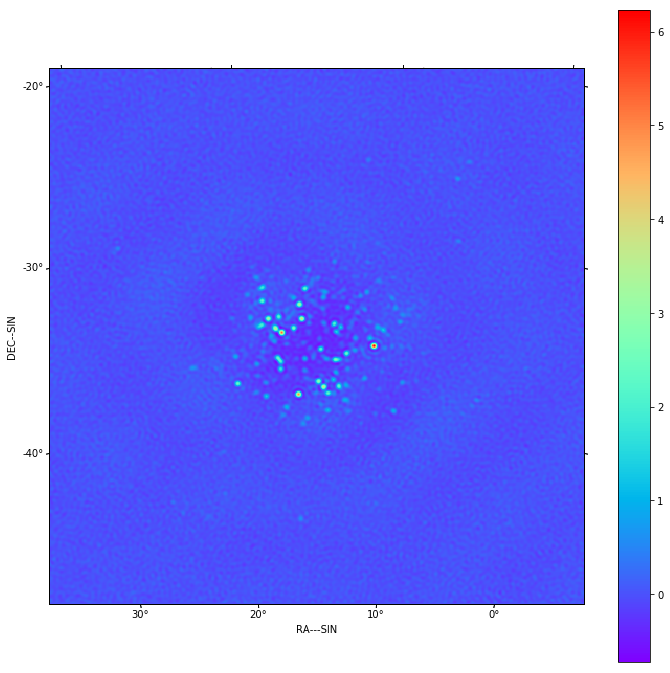

In [13]:
dirty, sumwt = invert_function(vt, model_multichannel, context='2d', padding=1)
show_image(dirty)
psf, sumwt = invert_function(vt, model_multichannel, context='2d', dopsf=True, padding=1)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %s" % 
      (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %s" % 
      (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-mfs-dirty.fits' % (results_dir))
export_image_to_fits(psf, '%s/imaging-mfs-psf.fits' % (results_dir))

deconvolve_cube: Multi-scale multi-frequency clean of each polarisation separately
calculate_image_frequency_moments: Reference frequency = 100000000.000 (MHz)
calculate_image_frequency_moments: Reference frequency = 100000000.000 (MHz)
deconvolve_cube: Processing pol 0
mmclean: Peak of PSF = 5.99953904295554 at (0, 256, 256)
mmclean: Peak of Dirty = 27.37307025118886 at (0, 259, 222)
mmclean: Moment-moment coupling matrix[scale 0] =
 [[ 1.00000000e+00 -3.33333144e-02  1.40740746e-02]
 [-3.33333144e-02  1.40740746e-02 -1.33333307e-03]
 [ 1.40740746e-02 -1.33333307e-03  3.78600815e-04]]
mmclean: Moment-moment coupling matrix[scale 1] =
 [[ 8.64152012e-01 -3.37671027e-02  1.25327996e-02]
 [-3.37671027e-02  1.25327996e-02 -1.28388950e-03]
 [ 1.25327996e-02 -1.28388950e-03  3.44142009e-04]]
mmclean: Moment-moment coupling matrix[scale 2] =
 [[ 2.01387913e-01 -1.87291097e-02  3.96178267e-03]
 [-1.87291097e-02  3.96178267e-03 -6.15404362e-04]
 [ 3.96178267e-03 -6.15404362e-04  1.26503660e-04

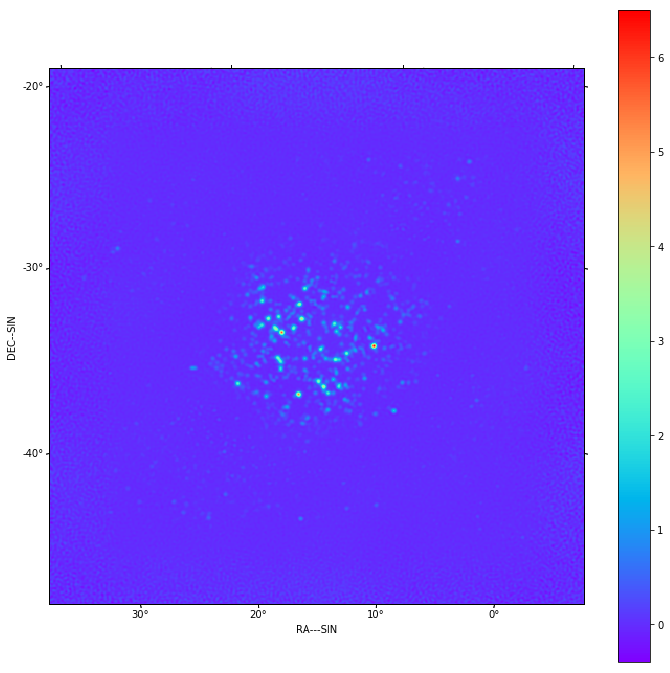

In [14]:
comp, residual = deconvolve_cube(dirty, psf, niter=1000, gain=0.7, algorithm='msmfsclean',
                scales=[0, 3, 10, 30], threshold=0.01, fractional_threshold=0.001, nmoments=3)
export_image_to_fits(comp, '%s/imaging-mfs-comp.fits' % (results_dir))
clean = restore_cube(model=comp, psf=psf, residual=residual)
export_image_to_fits(residual, '%s/imaging-mfs-residual.fits' % (results_dir))
export_image_to_fits(clean, '%s/imaging-mfs-clean.fits' % (results_dir))
show_image(clean)
plt.show()

Predict the visibility of the model

In [15]:
vtmodel = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_function(vtmodel, comp, context='2d')

create_visibility: 479325 rows, 0.050 GB
image_raster_iter: predicting using 1 x 1 image partitions


Now we will plot the original visibility and the residual visibility.

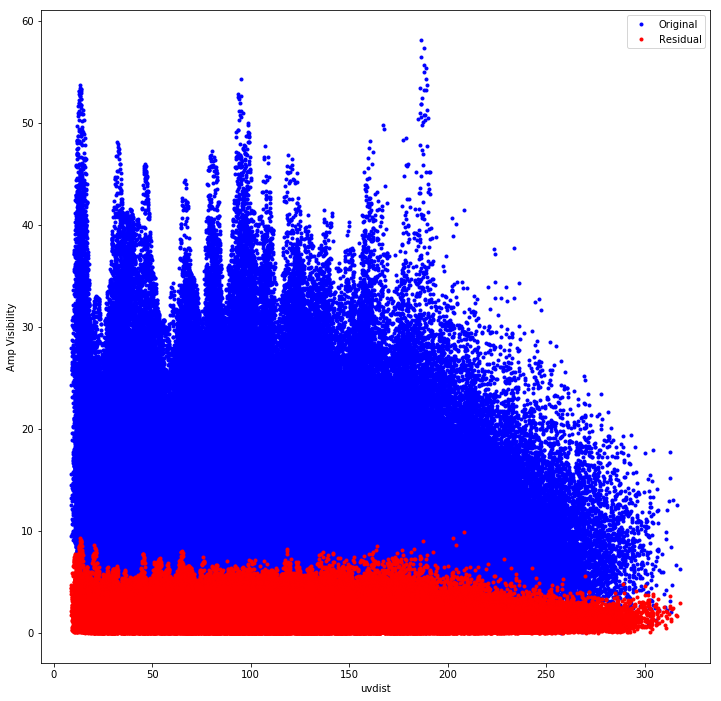

In [16]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis']-vtmodel.data['vis']), '.', color='r', 
         label='Residual')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()